# Содержание

1. Цель проекта

2. Загрузим данные подготовим их к анализу и ознакомимся с ними
   - Подключение необходимых библиотек
   - Считывание файла и ознакомление с данными
   - Преодбработка (проверим тип данных, дубликаты и пропуски)
   - Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
   - Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
   - Построим матрицу корреляций.
   - Вывод
3. Построим модель прогнозирования оттока клиентов
   - Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
   - Создадим модели бинарной классификации обучения с учителем, следующих алгоритмов: логистическая регрессия и случайный лес
4. Сделаем кластеризацию клиентов
   - Стандартизируем данные
   - Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
   - Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
   - Посмотрим на средние значения признаков для каждого из кластеров
   - Построим распределения признаков для кластеров
   - Для каждого полученного кластера посчитаем долю оттока
5. Общий вывод по проекту

## Цель проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространенная проблема подобных организаций это отток клиентов. В нашем распоряжении клиентская база анкет посетителей фитнес-центра.
Наша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами

## Загрузим данные и подготовим их к анализу

### Подключение необходимых библиотек

In [93]:
!pip install plotly

In [94]:
!pip -q install --upgrade sklearn

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
import plotly.express as px
from io import BytesIO
import requests
import math as mth
from scipy import stats as st


import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.metrics import silhouette_score

### Считывание файла и ознакомление с данными

In [96]:
data = pd.read_csv('/datasets/gym_churn.csv')
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [97]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Данные равномерные, стандартные отклонения не очень далеко от средних.

### Преодобработка

In [98]:
display(data.isna().sum()) #Пропусков не обнаружено
display(data.duplicated().sum()) #Дубликатов не обнаружено

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

0

In [99]:
#Приведем названия столбцов к корректому виду
data.columns = data.columns.str.lower()
data.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.22747,5.0,3,0.020398,0.0,0


In [100]:
#Приведем данные в столбце 'month_to_end_contract' к целочисленному
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [101]:
data_group = data.groupby('churn').mean().reset_index()
data_group.head()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


(-) "gender" (пол) - среднее одинаково, это говорит о том, что этот признак не влияет на отток/приток.(-)
(+-) "near_location" (проживание или работа рядом) - надо отметить высокий показатель и там и там - это значит большая часть клиентов, это те кто проживает и работает рядом. Можно сказать, что этот признак слабо влияет на отток.(+)
(+) "partner" - Также это поле оказавет положительное влияние на клиентов, - среди партнеров оттток меньше.(+)
(+) "promo_friends" - И это поле оказывает положительное влияние на клиентов, - отток среди "Промщиков" меньше.(+)
(-) "phone" - много тех кто оставил свои телефоны в анкете, но толку от этого мало :) - никакого влияния.(-)
(+) "contract_period" - довольно приличное положительное влияние на клиентов - это вполне логично, если у тебя уже куплен абонемент на год, за это заплачены деньги, есть стимул ходить, что бы деньги не пропали даром (нежели чем если ты купил на месяц,- здесь и бросить можно походив пару недель - и не жалко будет). Влияние признака на клиентов высокое.(+)
(+) "group_visits" - тоже оказывает сильное положительное влияние,- групповая терапия это хорошо:), если человек ходит в группы, он социализируется, появляются новые друзья связи и т.д., которые будут притягивать его в фитнес-центр.(+)
(+-) "age" - оказывает слабое положительное влияние на клиентов, - "спорту все возрасты покорны".(+-)
(+-) "avg_additional_charges_total" - выручка от других услуг - оказывает слабое положительное влияние, похоже люди неохотно тратят деньги на побочные услуги - их больше интересует то, что входит в абонемент.(+-)
(+) "month_to_end_contract" - сильное положительное влияние на клиентов. Еще много осталось отходить, обидно будет если столько добра пропадет даром.(+)
(+) "lifetime" - очень сильное положительное влияние на клиентов, - логично: чем дольше человек ходит, тем это сильнее закрепляется у него как привычка.(+)
(+-) "avg_class_frequency_total" - признак оказывает слабое положительное влияние. Все клиенты разные, все живут в разном темпе со своими делами и заботами, поэтому кто-то ходит каждый день, а кто-то раз в неделю, но все-таки чем чаще клиент ходит тем вероятность продолжать ходить больше - привычка.(+-)
(+) "avg_class_frequency_current_month" - все логично, чем чаще за неделю клиент ходил в фитнес в ближайщий период, тем привычка сильнее, - хорошее положительное влияние на клиентов.(+)

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

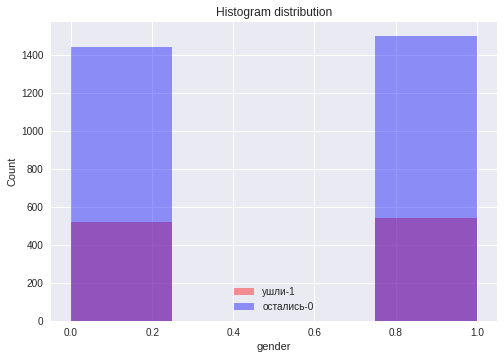

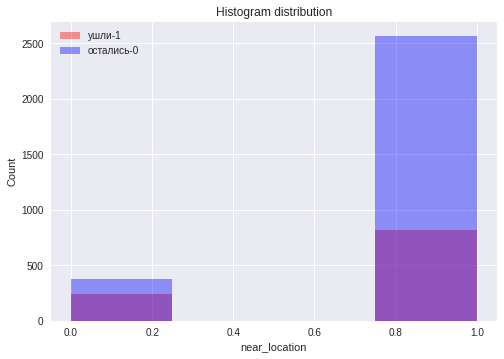

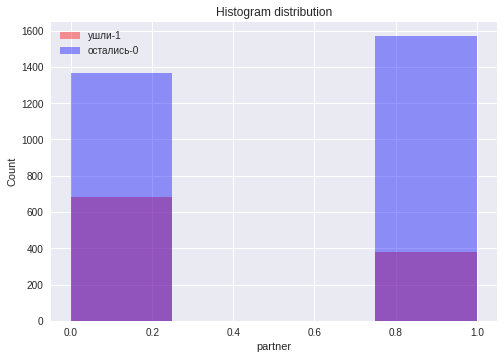

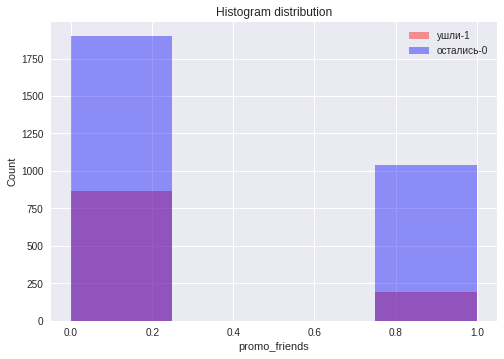

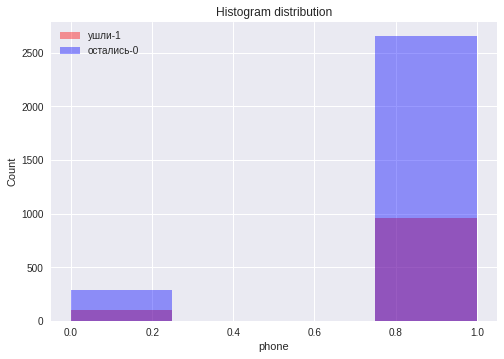

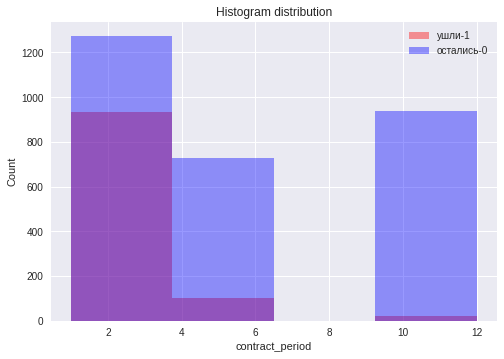

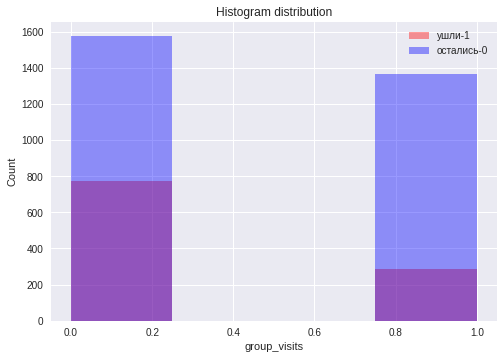

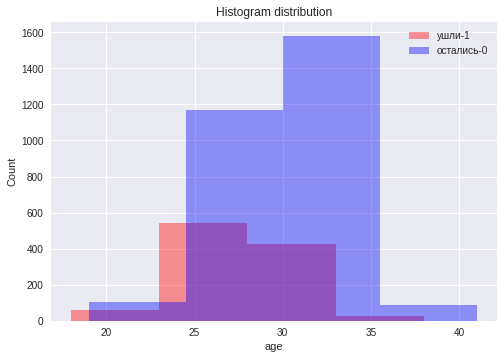

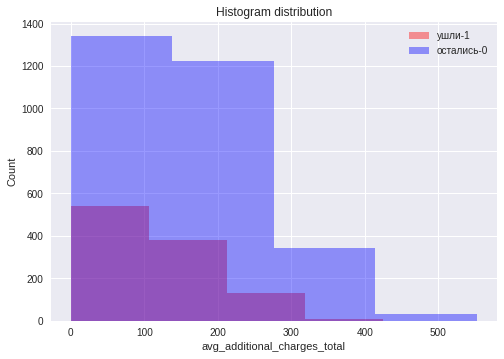

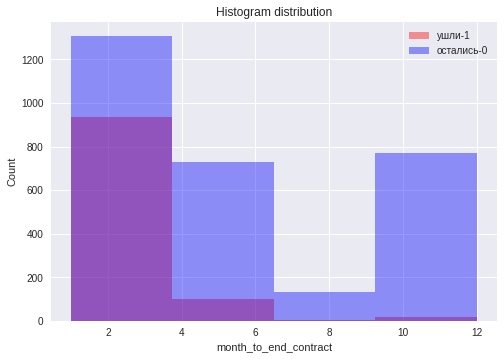

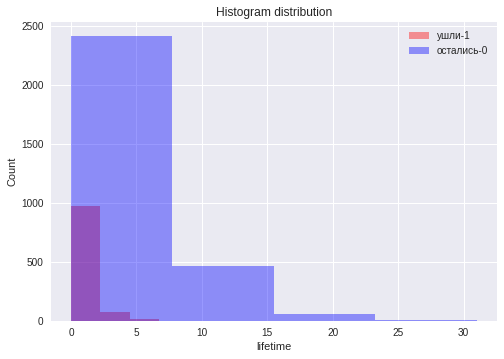

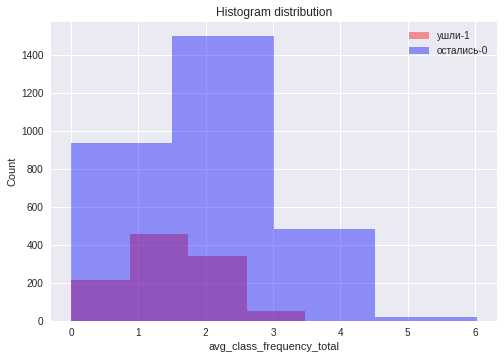

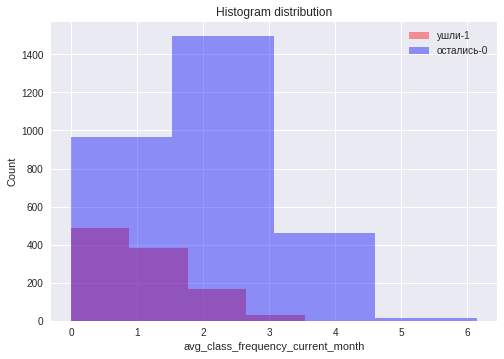

In [102]:
for i in data.drop('churn', axis=1).columns:
    sns.distplot(data.query('churn == 1')[i], bins=4, kde=False, color='red',label='ушли-1')
    sns.distplot(data.query('churn == 0')[i], bins=4, kde=False, color='blue',label='остались-0')
    plt.style.use('seaborn')
    plt.title('Histogram distribution')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

'gender' - И мужчин и женщин ходит примерно равное количество и доля оттока у них одинаковая.

'near_location' - Клиентов которые живут поблизости значительно больше, следовательно и доля оставшихся и ушедших выше.

'partner' - Количество партнеров немного выше, а вот доля оттока у них практически в 2 раза ниже.

'promo_friends' - Участников промо-акции значительно меньше, а доля оставшихся выше, доля оттока в сравнении с клиентами не учавствовавших в акции в 4 раза ниже.

'phone' - Очень многие оставляют свой номер телефона, никакого влияния на отток не наблюдается.

'contract_period' - Значительно больший отток среди тех кто заключает контракт на месяц, и очень высокая доля оставшихся тех кто заключает договор на год.

'group_visits' - Клиентов которые ходят на групповые занятия чуть меньше, однако доля оставшихся среди них заметно больше.

age' - После 30 лет люди охотнее остаются, "более дисциплинированы".

'avg_additional_charges_total' - Доля оставшихся и ушедших мало зависит от трат клиентами на доп услуги, да и потом большинство тратят не более 400.

'month_to_end_contract' - Здесь четко видно, что чем больше времени осталось до окончания договора тем меньше желание клиента уйти. И в целом отток наблюдается за теми кому остался месяц до конца договора.

'lifetime' - очень хорошо видно, что среди тех у кого большой "lifetime" оттока почти нет. Основной отток идет от тех кто ходил до 2 месяцев.

'avg_class_frequency_total' - У тех кто ходит 1-2 раза в неделю доля оттока примерно равна, и резко ситуация менятся для тех кто ходит 3 раза. У тех кто ходит 4-5 раза доля оттока совсем мала, скорее всего это профессиональные спортсмены.

'avg_class_frequency_current_month' - Чем чаще клиент ходил за последний месяц тем вероятность уйти ниже.

### Построим матрицу корреляций.

Text(0.5, 1.0, 'Matrix of correlations')

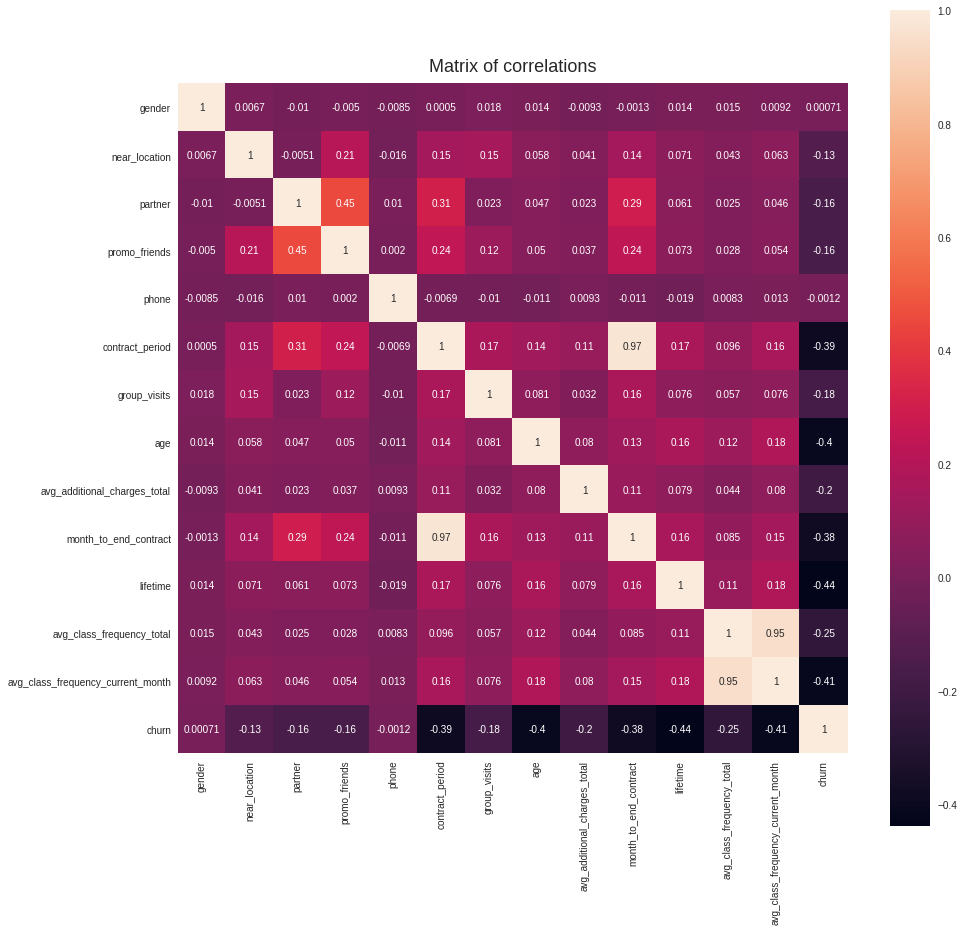

In [103]:
data_corr = data.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(data_corr, square=True, annot=True)
sns.set_palette('dark')
ax.set_title('Matrix of correlations', fontdict={'fontsize':18}, pad=12)

Здесь общая картина похожа на, ту которая в пункте 2.2. Но есть и отличия. По карте видно, что 'partner', 'group_visits', 'promo_friends' - оказывают все-таки очень слабое влияние, а 'age' наоборот более сильное

На карте между 'churn' и признаками видна обратная корреляция - это говорит о том, что чем сильнее признак, тем слабее отток.

По цифрам корреляции можно сказать, что все признаки слабо коррелируют:

1. 'gender' и 'phone' - никакого влияния признаков на 'churn'. Корреляция почти 0  

2. near_location', 'partner', 'promo_friends', 'group_visits', 'avg_additional_charges_total', 'avg_class_frequency_total'. Корреляция в диапазоне -(0,1-0,25) - очень слабая.  

3. 'contract_period', 'age', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_current_month'. Корреляция в диапазоне -(0,38-0,44) - просто слабая.

Также надо отметить очень сильную (выше 0,95) корреляцию пар признаков, которую надо будет учесть в моделях линейной регрессии:
а) 'contract_period' и 'month_to_end_contract'- чем больше период абонемента, тем скорее всего больше месяцев осталось;
б) 'avg_class_frequency_current_month' и 'avg_class_frequency_total' - здесь очень логично, те кто давно уже ходит с постоянным графиком, тот и за последний месяц ходил скорее всего с таким же графиком.

Удалим по одному столбцу из каждой пары чтобы исключить мультикорреляцию

In [104]:
data = data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


Вывод:
Всего 4000 записей, то есть в исследовании участвуют 4000 клиентов, это достаточная цифра для осуществления прогноза.
Данные чистые, пропусков и дубликатов нет
Был изменен тип данных столбца 'month_to_end_contract' и приведен к целочисленному типу (количество полных месяцев до окончании контракта)
Все названия столбцов были приведены к корректному виду (нижний регистр)
'gender' и 'phone' признаки которые не оказывают никакого влияния на отток клиентов
'near_location', 'partner', 'promo_friends', 'group_visits', 'avg_additional_charges_total', 'avg_class_frequency_total' имеют слабую корреляцию.
'contract_period', 'age', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_current_month' имеют корреляцию чуть ниже средней.
Есть две пары признаков которые имеют взаимную корреляцию и этот факт необходимо учитывать при построении модели прогнозирования для линейной регрессии.

## Построим модель прогнозирования оттока клиентов

### Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

Получим матрицу признаков Х и целевую переменную y

In [105]:
X = data.drop('churn', axis=1)
y = data['churn']

Разделяем модель на обучающую и валидационную выборку

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Cоздадим объект класса StandardScaler и применим его к обучающей выборке

In [107]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

Применяем стандартизацию к матрице признаков для тестовой выборки

In [108]:
X_test_st = scaler.transform(X_test)

### Создадим модели бинарной классификации обучения с учителем, следующих алгоритмов: логистическая регрессия и случайный лес

Создадим список моделей

In [109]:
models = [LogisticRegression(random_state=0), RandomForestClassifier(n_estimators = 100, random_state=0)]

Напишем функцию посчета метрик для выбранных нами моделей

In [110]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(accuracy_score(y_test, y_pred),
                                                                     precision_score(y_test, y_pred),
                                                                     recall_score(y_test, y_pred)))

Напишем функцию вывода метрик в сосответствии с моделями

In [111]:
for i in models:
    print(i)
    make_prediction(
    m = i,
    X_train = X_train_st,
    y_train = y_train,
    X_test = X_test_st,
    y_test = y_test) 

LogisticRegression(random_state=0)
Accuracy: 0.90 Precision: 0.79 Recall: 0.82
RandomForestClassifier(random_state=0)
Accuracy: 0.90 Precision: 0.81 Recall: 0.75


По параметру Accuracy "Логистическая регрессия" и "Случайный лес" одинаковы (0,92), по precision "Логистическая регрессия" получше (0,85 проитив 0,84) и также немного лучше по recall (0,83 против 0,81)

По всем параметрам "Логистическая регрессия" дает результат немного лучше чем "Случайный лес"

Также надо отметить у обоих моделей очень высокий показатель Accuracy (больше 0,91), а также высокие показатели precision и recall (в диапазоне 0,81 - 0,85)

Вывод: В общем и целом обе модели показали вполне отличные результаты, "Логистическая регрессия" - немного лучше.

Версия 2 после удаления столбцов

По параметру Accuracy "Логистическая регрессия" и "Случайный лес" одинаковы (0,90), по precision "Логистическая регрессия" немного проигрывает (0,79 проитив 0,81), а вот recall много лучше (0,82 против 0,75)

В целом "Логистическая регрессия" дает результат немного лучше чем "Случайный лес"

Также надо отметить у обоих моделей очень высокий показатель Accuracy (0,90), а также высокие показатели precision и recall (в диапазоне 0,75 - 0,82)

Вывод: В общем и целом обе модели показали вполне отличные результаты, "Логистическая регрессия" - немного лучше.

## Сделаем кластеризацию клиентов

### Стандартизируем данные

In [112]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:3]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121, -0.19332863,
        -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  0.87368001,
         0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.46008079,
        -0.02901851]])

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

Создадим таблицу связок между объектами

In [113]:
linked = linkage(X_sc, method = 'ward') 

Отобразим дендограмму

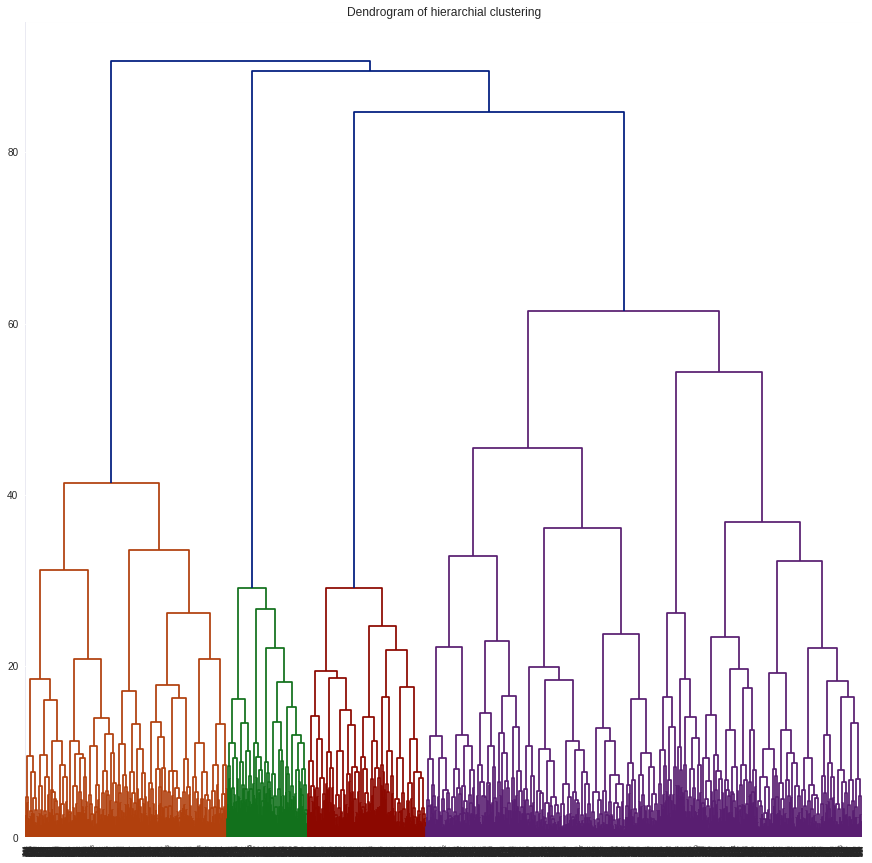

In [114]:
plt.figure(figsize=(15, 15))
dendrogram(linked, orientation='top')
plt.title('Dendrogram of hierarchial clustering')
plt.show() 

Явно выделяются 4 кластера (4 цвета) я бы выбрал 5

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

За число кластеров примим n=5

In [115]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

Cохраним метки кластера в поле нашего датасета

In [116]:
data['cluster_km'] = labels
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


Посмотрим распределение количества клиентов по кластерам

In [117]:
data_cluster_count = data.groupby('cluster_km').agg({'gender': 'count'}).reset_index()
data_cluster_count.head()

,cluster_km,gender
0,0,985
1,1,558
2,2,1064
3,3,1007
4,4,386


Text(0.5, 1.0, 'Number of users in the cluster')

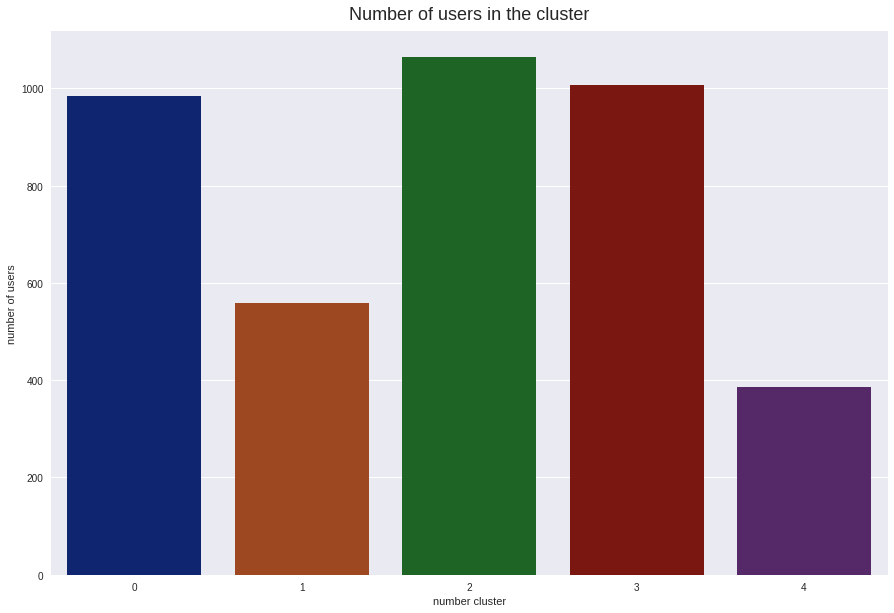

In [118]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=data_cluster_count['cluster_km'], y=data_cluster_count['gender'])
sns.set_palette('dark')
plt.xlabel('number cluster')
plt.ylabel('number of users')
ax.set_title('Number of users in the cluster', fontdict={'fontsize':18}, pad=12)

Три кластера распределились достаточно равномерно

Посмотрим на метрику силуэта, она покажет насколько качественно прошла кластеризация. Оно принимает значение от -1 до 1, чем ближе к единицы тем лучше.

In [119]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Судя по значению метрики в 0.14, кластеризация прошла плохо. 

### Посмотрим на средние значения признаков для каждого из кластеров

In [120]:
data_cluster = data.drop('churn', axis=1).groupby('cluster_km').mean().T
display(data_cluster)

cluster_km,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


Кластер 0:
"contract_period" самые высокие показатели этого признака и соответственно "month_to_end_contract". Говорит о том что большинство клиентов этого кластера оформляют договор на год. Здесь так же и самый высокий показатель "lifetime".
"partner" 78% самый высокий процент среди групп. 
В этом кластере должны быть очень низкие показатели оттока, в основном это сотрудники компании.

Кластер 1:
"phone" = 0
Те кто не оставил номер телефона

Кластер 2:
"near_location" = 0
"promo_friends" = 8%
"group_visits" = 22%
Клиенты которые живут явно не близко, в основном все пришли без промо-акций и не любят групповые занятия. 

Кластер 3:
"lifetime" самый низкий 2.4
"avg_class_frequency_total" = 1,25
"avg_class_frequency_current_month" = 1,01
Самый проблемный кластер, именно он составляет большую долю оттока клиентов. Здесь низкий лайфтайм, частота посещений около 1 раза в неделю, а оформленный договор на месяц.

Кластер 4:
"lifetime" самый высокий 4.89
"avg_class_frequency_total" = 2,85
"avg_class_frequency_current_month" = 2,85
Этот кластер противоположен 3: высокий лайфтайм, частота посещений около 3 раз в неделю, любят групповые занятия. Здесь отток должен быть минимальным или близко к этому.

Версия 2 после удаления столбцов

Кластер 0:
"contract_period" самые высокие показатели этого признака. Говорит о том что большинство клиентов этого кластера оформляют договор на год. Здесь так же высокий показатель "lifetime" 4.28.
"partner" 89% самый высокий процент среди групп.
В этом кластере должны быть небольшие показатели оттока, в основном это сотрудники компании.
Все клиенты из этого кластера пришли по промо-акции

Кластер 1:
"near_location" = 0
Здесь самый низкий показатель "group_visits" 0.23 и "lifetime" ниже среднего, все клиенты проживают далеко от фитнес-центра

Кластер 2:
"lifetime" = 1.9 самый низкий среди всех, хотя 100% всей группы проживают в непосредственной близости от фитнес-центра. Большинство клиентов заключают контракт на месяц "contract_period" 2.01. Не очень любят групповые занятия 28%

Кластер 3:
"lifetime" = 5.42
"group_visits" = 54%
"contract_period" = 6.21
Почти все 100% группы проживает недалеко от фитнес-центра, практически полностью отсутствуют клиенты по промо-акции. Главное что большинство клиентов покупают абонемент сразу на год. Самый высокий лайфтайм и процент групповых занятий. Отток клиентов здесь должен быть минимальным.

Кластер 4:
Та самая загадочная группа которая не оставила номера телефонов. Такие показатели как: "lifetime", "group_visits" и "contract_period" на среднем уровне относительно других кластеров. Но здесь меньшее количество партнеров чем в 0-ом кластере примерно половина, и 14% далеко добираться. 

### Построим распределения признаков для кластеров

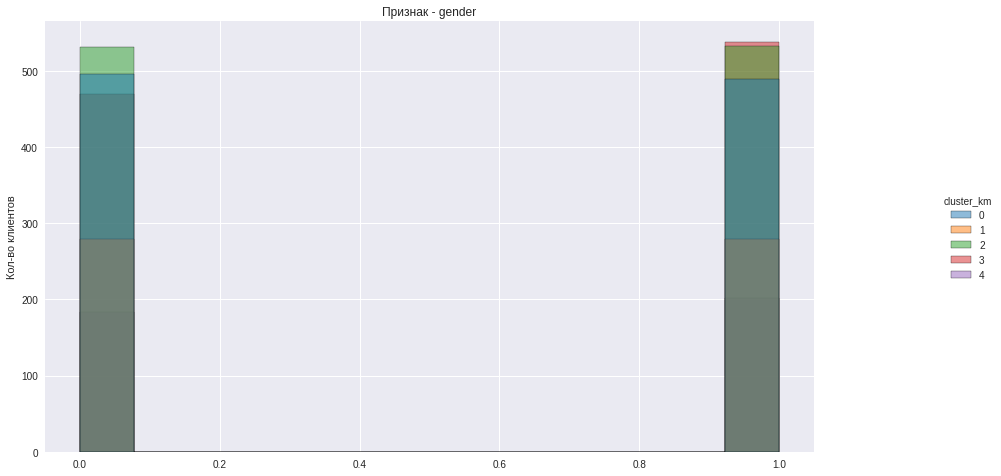

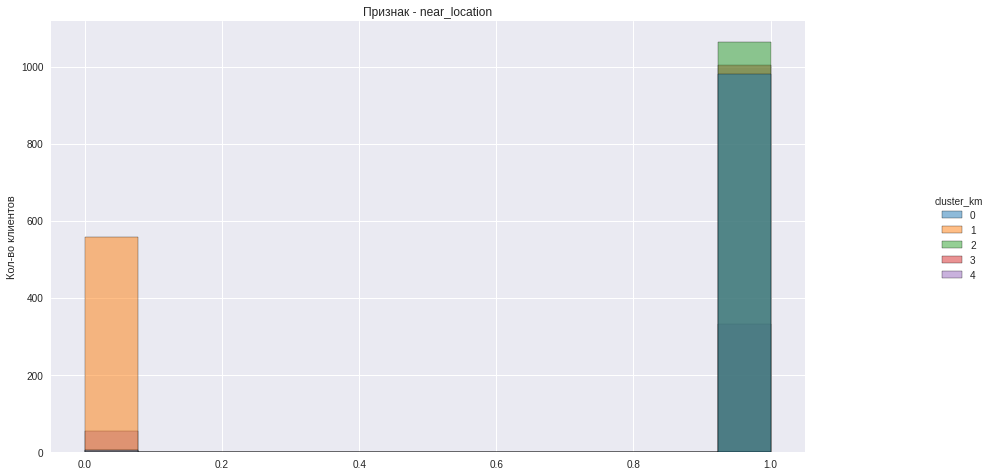

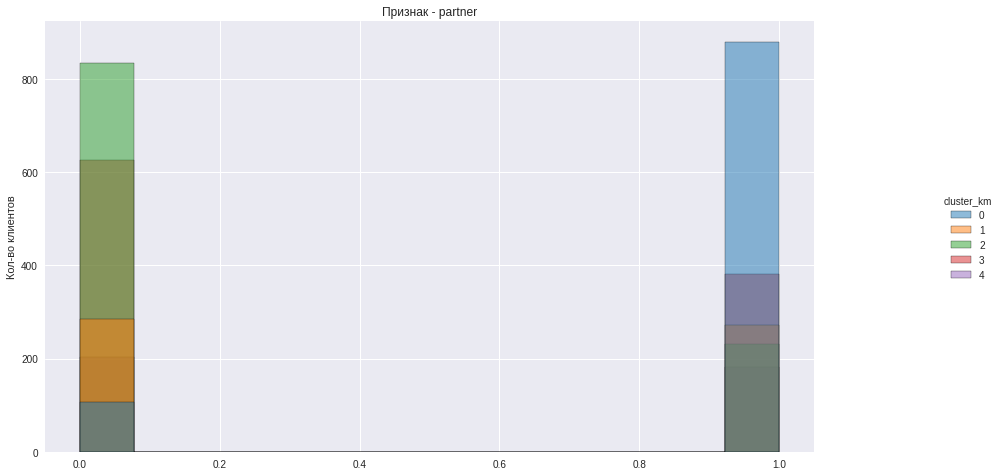

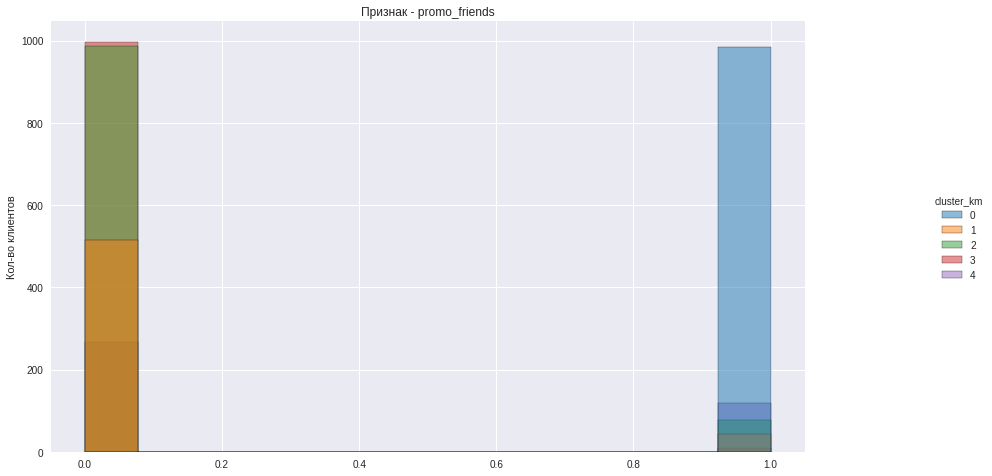

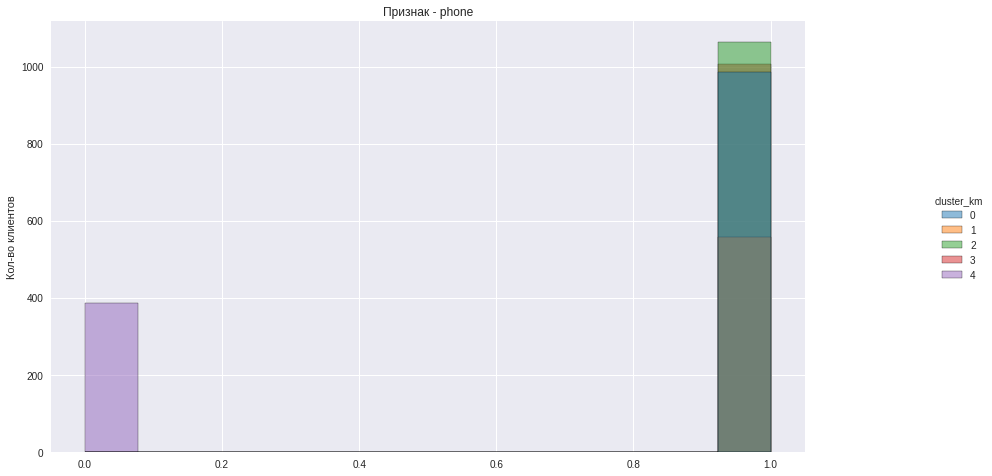

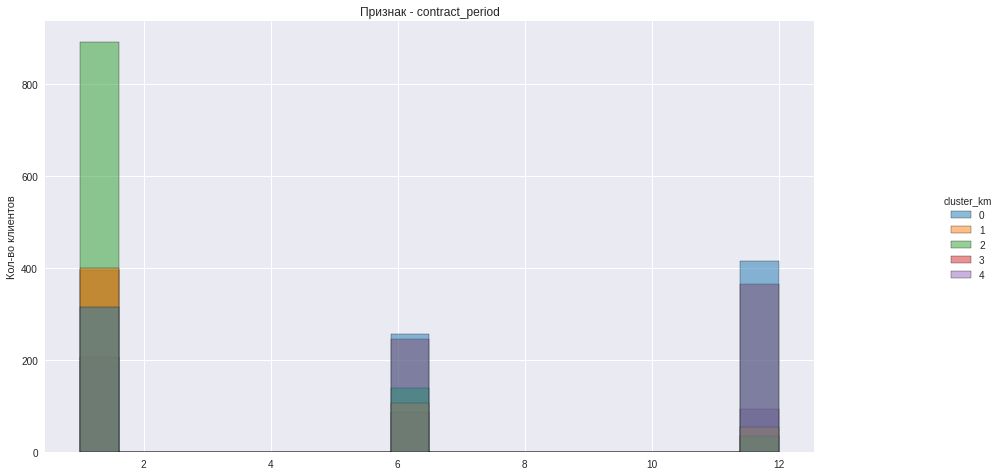

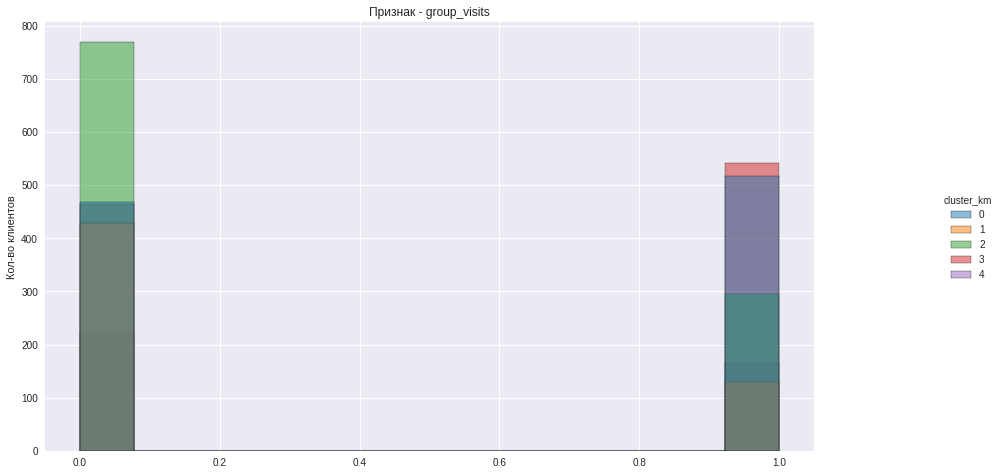

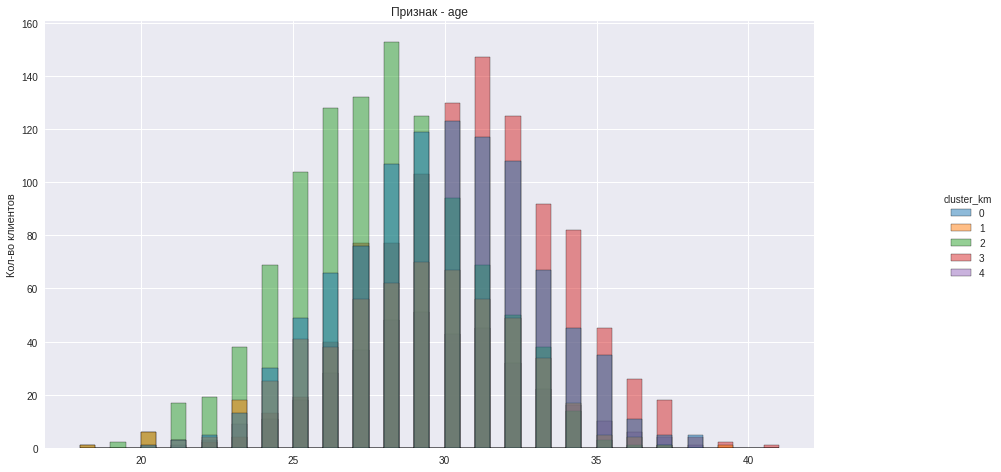

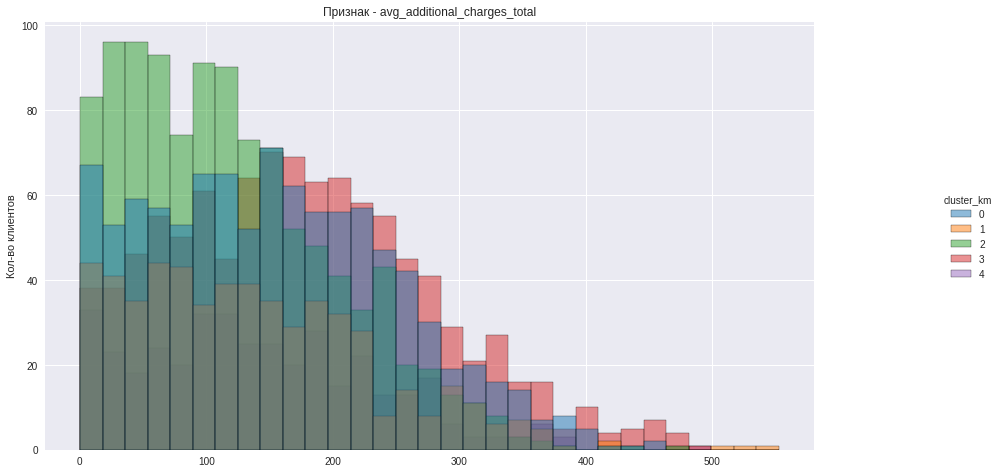

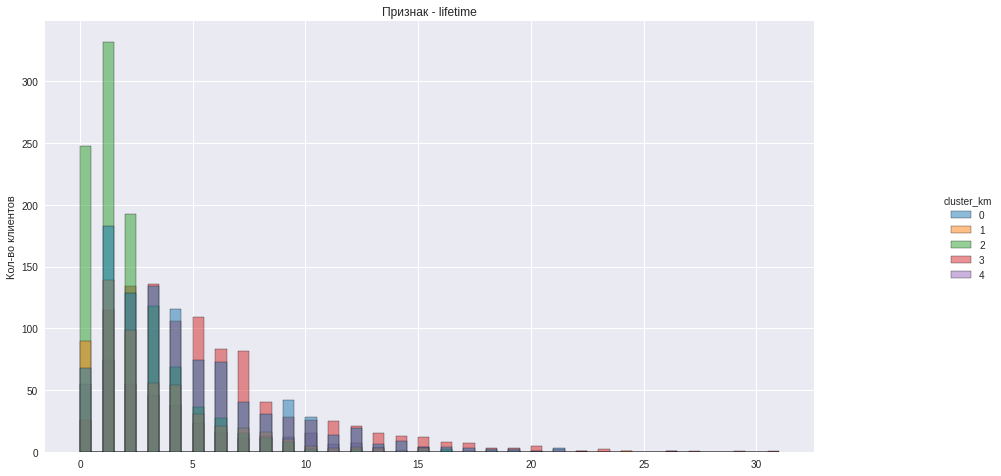

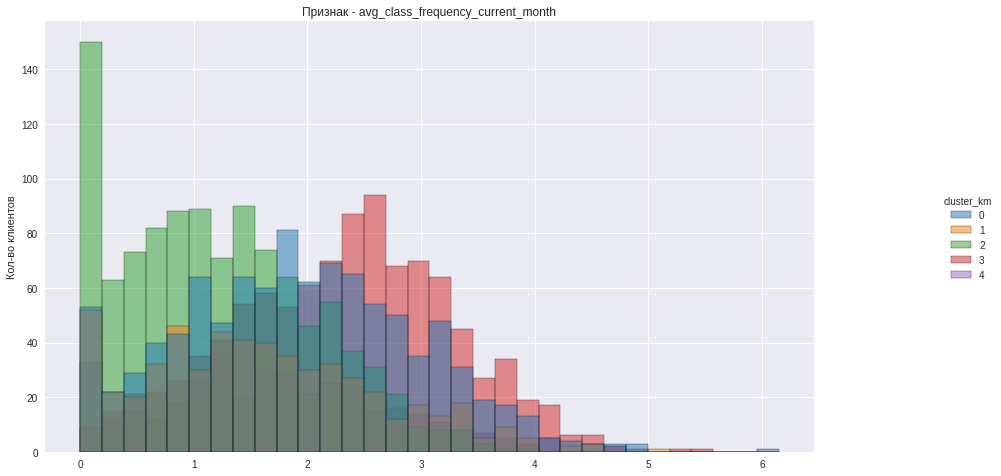

In [121]:
for i in data.drop(['cluster_km', 'churn'], axis=1).columns:
    ax = sns.displot(data, x=data[i], hue='cluster_km', palette="tab10", kind='hist')
    plt.title(f'Признак - {i}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")
    ax.fig.set_figwidth(15)
    ax.fig.set_figheight(7)

'gender' - Чего-то явного нет.

'near_location' - Клиенты которые живут далеко в основном входят в кластер 2.

'partner' - Кластеры 1 и 3 - те кто не являются партнерами, 0 и 4 - партнеры.

'promo_friends' - Так же как и в предыдущем 0 и 4 - участники акции, 1 и 3 - нет.

'phone' - Все оставляют номер телефона кроме 1 кластера.

'contract_period' - В кластере 0 в основном те кто заключают контракт на год, а в 3 тех кто на 1 месяц.

'group_visits' - В 3 кластере не любят групповые занятия, а в 0 наоборот.

age' - В кластере 3 клиенты до 30 лет, а в кластере 0 30+.

'avg_additional_charges_total' - Снова выделяются кластер 3 и 0, в 3 клиенты тратят до 200 на доп услуги, а в 0 свыше 200. Это вполне логично люди по старше и зарабатывают больше.

'month_to_end_contract' - В кластере 0 больше времени остается до окончания контракта т.к. многие многие его оформляют либо на год либо на пол года.

'lifetime' - в 3 кластер входят те кто ходил 0-2 месяца, а в 0 больше 2-ух месяцев.

'avg_class_frequency_total' - В кластер 3 - те кто ходит в среднем 1 раз, кластер 0 и 4 - те кто ходит 2-3раза.

'avg_class_frequency_current_month' - Так же как и впредыдущем пункте, что абсолютно логично учитывая высокий уровень корреляции этих признаков.

Версия 2 после удаления столбцов

'gender' - Чего-то явного нет.

'near_location' - Клиенты которые живут далеко в основном входят в кластер 1.

'partner' - Партнеры в основном в 0-ом кластере.

'promo_friends' - Участники акции почти все в 0-ом кластере и немного в 4-ом.

'phone' - Все оставляют номер телефона кроме 4-ого кластера.

'contract_period' - В кластере 0 в основном те кто заключают контракт на год, а в 2-ом тех кто на 1 месяц.

'group_visits' - В 2-ом кластере не любят групповые занятия, а в 3-ем наоборот.

age' - В кластере 2 клиенты до 30 лет, а в кластере 3 и 4 30+.

'avg_additional_charges_total' - В кластерах 3 и 4, клиенты тратят свыше 150 на доп услуги, а в 2 до 150. Это вполне логично люди по старше и зарабатывают больше.

'lifetime' - в 2-ом кластере входят те кто ходил 0-2 месяца, а в 3-ем и 4-ом больше 2-ух месяцев.

'avg_class_frequency_current_month' - В кластере 2 - те кто ходит в среднем 1-2 раза, кластере 3 и 4 - те кто ходит в среднем 3 раза.

### Для каждого полученного кластера посчитаем долю оттока

In [122]:
data_share = data.query('churn==1').groupby('cluster_km')['churn'].count() / data.query('churn==1')['churn'].count()
data_share.head()

cluster_km
0    0.111216
1    0.212064
2    0.565504
3    0.014138
4    0.097078
Name: churn, dtype: float64

Как и предполагалось самая большая доля ушедших клиентов приходится на 3 кластер 61%. Самые хорошие результаты у 4-ого и 0-го кластера 5 и 3 % соответственно. Во втором кластере отток составил 21% , что в два раза больше чем в группе клиентов не оставивших номер телефона.

Версия 2 после удаления столбцов

Как и предполагалось самая большая доля ушедших клиентов приходится на 2 кластер 56%. Самые хорошие результаты у 3-его всего 1%. У 0-ого и 4-ого примерно равные показатели  11% и 10%. В первом кластере отток составил 21%.

## Общий вывод по проекту

1. Предобработка и исследовательский анализ данных (EDA)
На первом этапе мы ознакомились с данными и выполнили предобработку, привели названия столбцов к нужному регистру, заменили тип данных. Посмотрели как распределяются признаки в соответствии с активными клиентами и теми кто ушел. Построили матрицу корреляции и определили обратную зависимость оттока от признаков. Соответственно чем сильнее признак тем меньше вероятность оттока. Самые "положительные" признаки: ('age', 'contract_period', 'lifetime', 'avg_class_frequency_current_month' 0.39-0.44). Признаки с самой низкой корреляцией: (gender, phone). Были обнаружены две пары зависимых между собой признаков с корреляцией 0.95+
В целях улучшения линейных моделей необходимо было убрать мультикорреляционные признаки, потому столбцы: 'month_to_end_contract', 'avg_class_frequency_total' были удалены из датафрейма. Версия 2 в описании является конечной.

2. Прогноз
Построение прогноза осуществлялось при помощи моделей "Логистической регрессии" и "Случайного леса". В обоих вариантах метрики получили высокие показатели 0.75+, Accuracy в двух моделях набрала аж 0.90. В целом по трем метрикам "Логистическая регрессия" дала чуть более лучший результат чем "Случайный лес".

3. Кластеризация
По результатам дендрограммы было принято решение разбить клиентов на 5 кластеров. Для оценки качества проведенного нами разбиения была посчитана метрика силуэта: 0.14 - исходя из этого можно сказать, что кластеризация прошла неудачно.

Результаты:

Кластер 0 - средний кластер, отток 11% от общего.
Это в основном клиенты, кто купил абонемент на 12мес, но ходят в среднем 2 раза в неделю. Почти все проживают рядом и все 100% являются участниками промо-акции. 89% является партнерами. И здесь так же как и в 3-ем кластере любят групповые занятия 52%

Кластер 1 - достаточно плохой, кластер, доля оттока составляет 21% от общего.
Это те клиенты которые проживают далеко от фитнес-центра. именно это и играет ключевую роль в высоком проценте оттока. Типичные одиночки - самый низкий процент групповых занятий 23%, "lifetime" ниже среднего относительно других кластеров 2.97. Здесь в основном покупают абонементы как на месяц так и на пол года.

Кластер 2 - худший, кластер, доля оттока составляет 56,6% от общего.
Все клиенты проживают близко и несмотря на это здесь самый высокий отток клиентов. Самый низкий лайфтайм и большинство контрактов заключаются сроком на 1 месяц. Участников промо-акции практически нет, групповые занятия 28%.

Кластер 3 - лучший кластер, отток рекордный, всего 1% от общего.
Здесь клиенты настоящие любители фитнеса, высокий процент посещения групповых занятий(54%), заключают договор в основном на год. Частота посещений таких пользователей в среднем составляет 3 раза в неделю. Партнерами являются 38% и почти все пришли без промо-акций. Контенгент в основном  30+ лет, тратят на доп. услуги свыше 150. Самый высокий "lifetime" - 5.42

Кластер 4 - средний кластер, отток 10% от общего.
Загадочная группа которая не оставляет номер телефона, самый плохо интерпритируемый кластер. Здесь все показатели в основном на среднем уровне по отношению к другим кластерам. 31% - участники промо-акции и 47% это партнеры. Большинство 86% проживают в непосредственной близости от фитнес-центра. Контенгент, как и в 3-ем кластере, в основном  30+ лет, тратят на доп. услуги свыше 150.

4. РЕКОМЕНДАЦИИ:

Целевая аудитория клиенты в возрасте 30+ проживающие недалеко от фитнес-центра.

Необходимо создавать приятную атмосферу и поддерживать сервис и чистоту, для того чтобы клиенты посещали зал 2-3 раза в неделю.
Больше внимания уделять целевой аудитории.
Привлекать большее число клиентов к промо-акциям, а партнеров наоборот можно лишить этой возможности.
Учитывая особенности проблемных кластеров (1 и 2), чтобы снизить отток в этих группах, рекомендуется делать скидки на приобретение годового абонемента, именно у этих пользователей лучшие показатели. В качестве бонуса при заключении договора на год предоставлять первое занятие в группе на одном из спортивных дисциплин бесплатно, таким образом можно привлечь клиентов к этой активности, а она уже в свою очередь повысит посещаемость и как следствие вероятность дальнейшего сотрудничества.